## Import Library

In [33]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

## Data Loading

In [34]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

## Data Understanding

Kode ini digunakan untuk melakukan data understanding dengan cara menganalisis distribusi jumlah gambar pada setiap label dalam dataset. Pertama, kode menghitung jumlah kemunculan masing-masing label menggunakan np.unique dengan opsi return_counts=True, lalu mengurutkan label dan jumlahnya agar lebih rapi saat divisualisasikan. Visualisasi dilakukan menggunakan grafik batang (bar chart) untuk menampilkan jumlah gambar per label, lengkap dengan rotasi label agar mudah dibaca. Setelah itu, informasi jumlah total data, jumlah label unik, dan distribusi data per label dicetak ke terminal untuk memberikan gambaran umum tentang keseimbangan kelas dalam dataset citra apel yang digunakan.

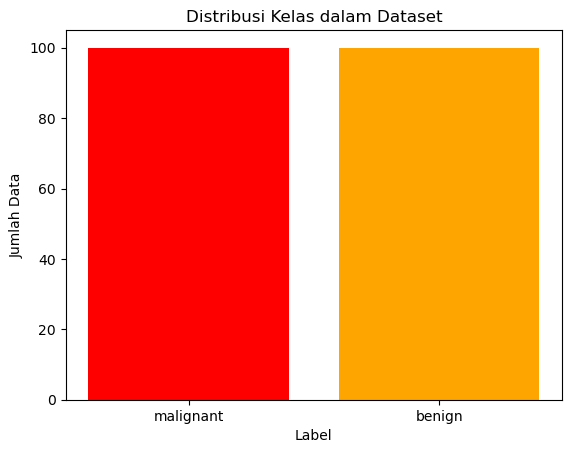

In [35]:
class_count = Counter(labels)

label_names = list(class_count.keys())
jumlah = list(class_count.values())

plt.bar(label_names, jumlah, color=['red', 'orange'])
plt.title("Distribusi Kelas dalam Dataset")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.show()

## Data Preparation

### Define Preprocessing Function


In [36]:
# Resize
def resize(img, baris_baru, kolom_baru):
    baris_asli, kolom_asli = img.shape

    result = np.zeros((baris_baru, kolom_baru), dtype=np.uint8)

    for i in range(baris_baru):
        for j in range(kolom_baru):
            x = int(i * baris_asli / baris_baru)
            y = int(j * kolom_asli / kolom_baru)

            x = min(x, baris_asli - 1)
            y = min(y, kolom_asli - 1)

            result[i, j] = img[x, y]

    return result

# Median Filtering
def median_filter(img, size=(3, 3)):
    result = np.zeros(img.shape, img.dtype)

    half_kern_size = (size[0]//2 ,size[1]//2)
    padded = np.pad(img, pad_width=half_kern_size, mode="edge")
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            temp = np.sort(padded[y:y+size[0], x:x+size[1]].flatten())[(size[0] * size[1]) // 2]
            result[y,x] = temp

    return result

# Deteksi Tepi Roberts Operator
def roberts_operator(img):
    kernel = np.array([[[1, 0],
                        [0, -1]],
                        
                        [[0, 1],
                        [-1, 0]]])

    result = np.zeros(img.shape, dtype = img.dtype)

    padded = np.zeros((img.shape[0] + 1, img.shape[1] + 1), dtype=img.dtype)
    padded[1:, 1:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

# Deteksi Sobel Operator
def sobel_operator(img):
    kernel = np.array([
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]],

        [[1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]]])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=img.dtype)
    padded[2:, 2:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

# Treshold
def treshold(img, value = 100):
    result = np.zeros(img.shape, img.dtype)
    result[img > value] = 255
    
    return result

### Preprocessing

In [ ]:
dataPreprocessed = []
for i in range(len(data)):
    img = median_filter(data[i])
    img = roberts_operator(img)
    img = sobel_operator(img)
    img = treshold(img)
    
    dataPreprocessed.append(img)

TypeError: median_filter() takes from 1 to 2 positional arguments but 3 were given

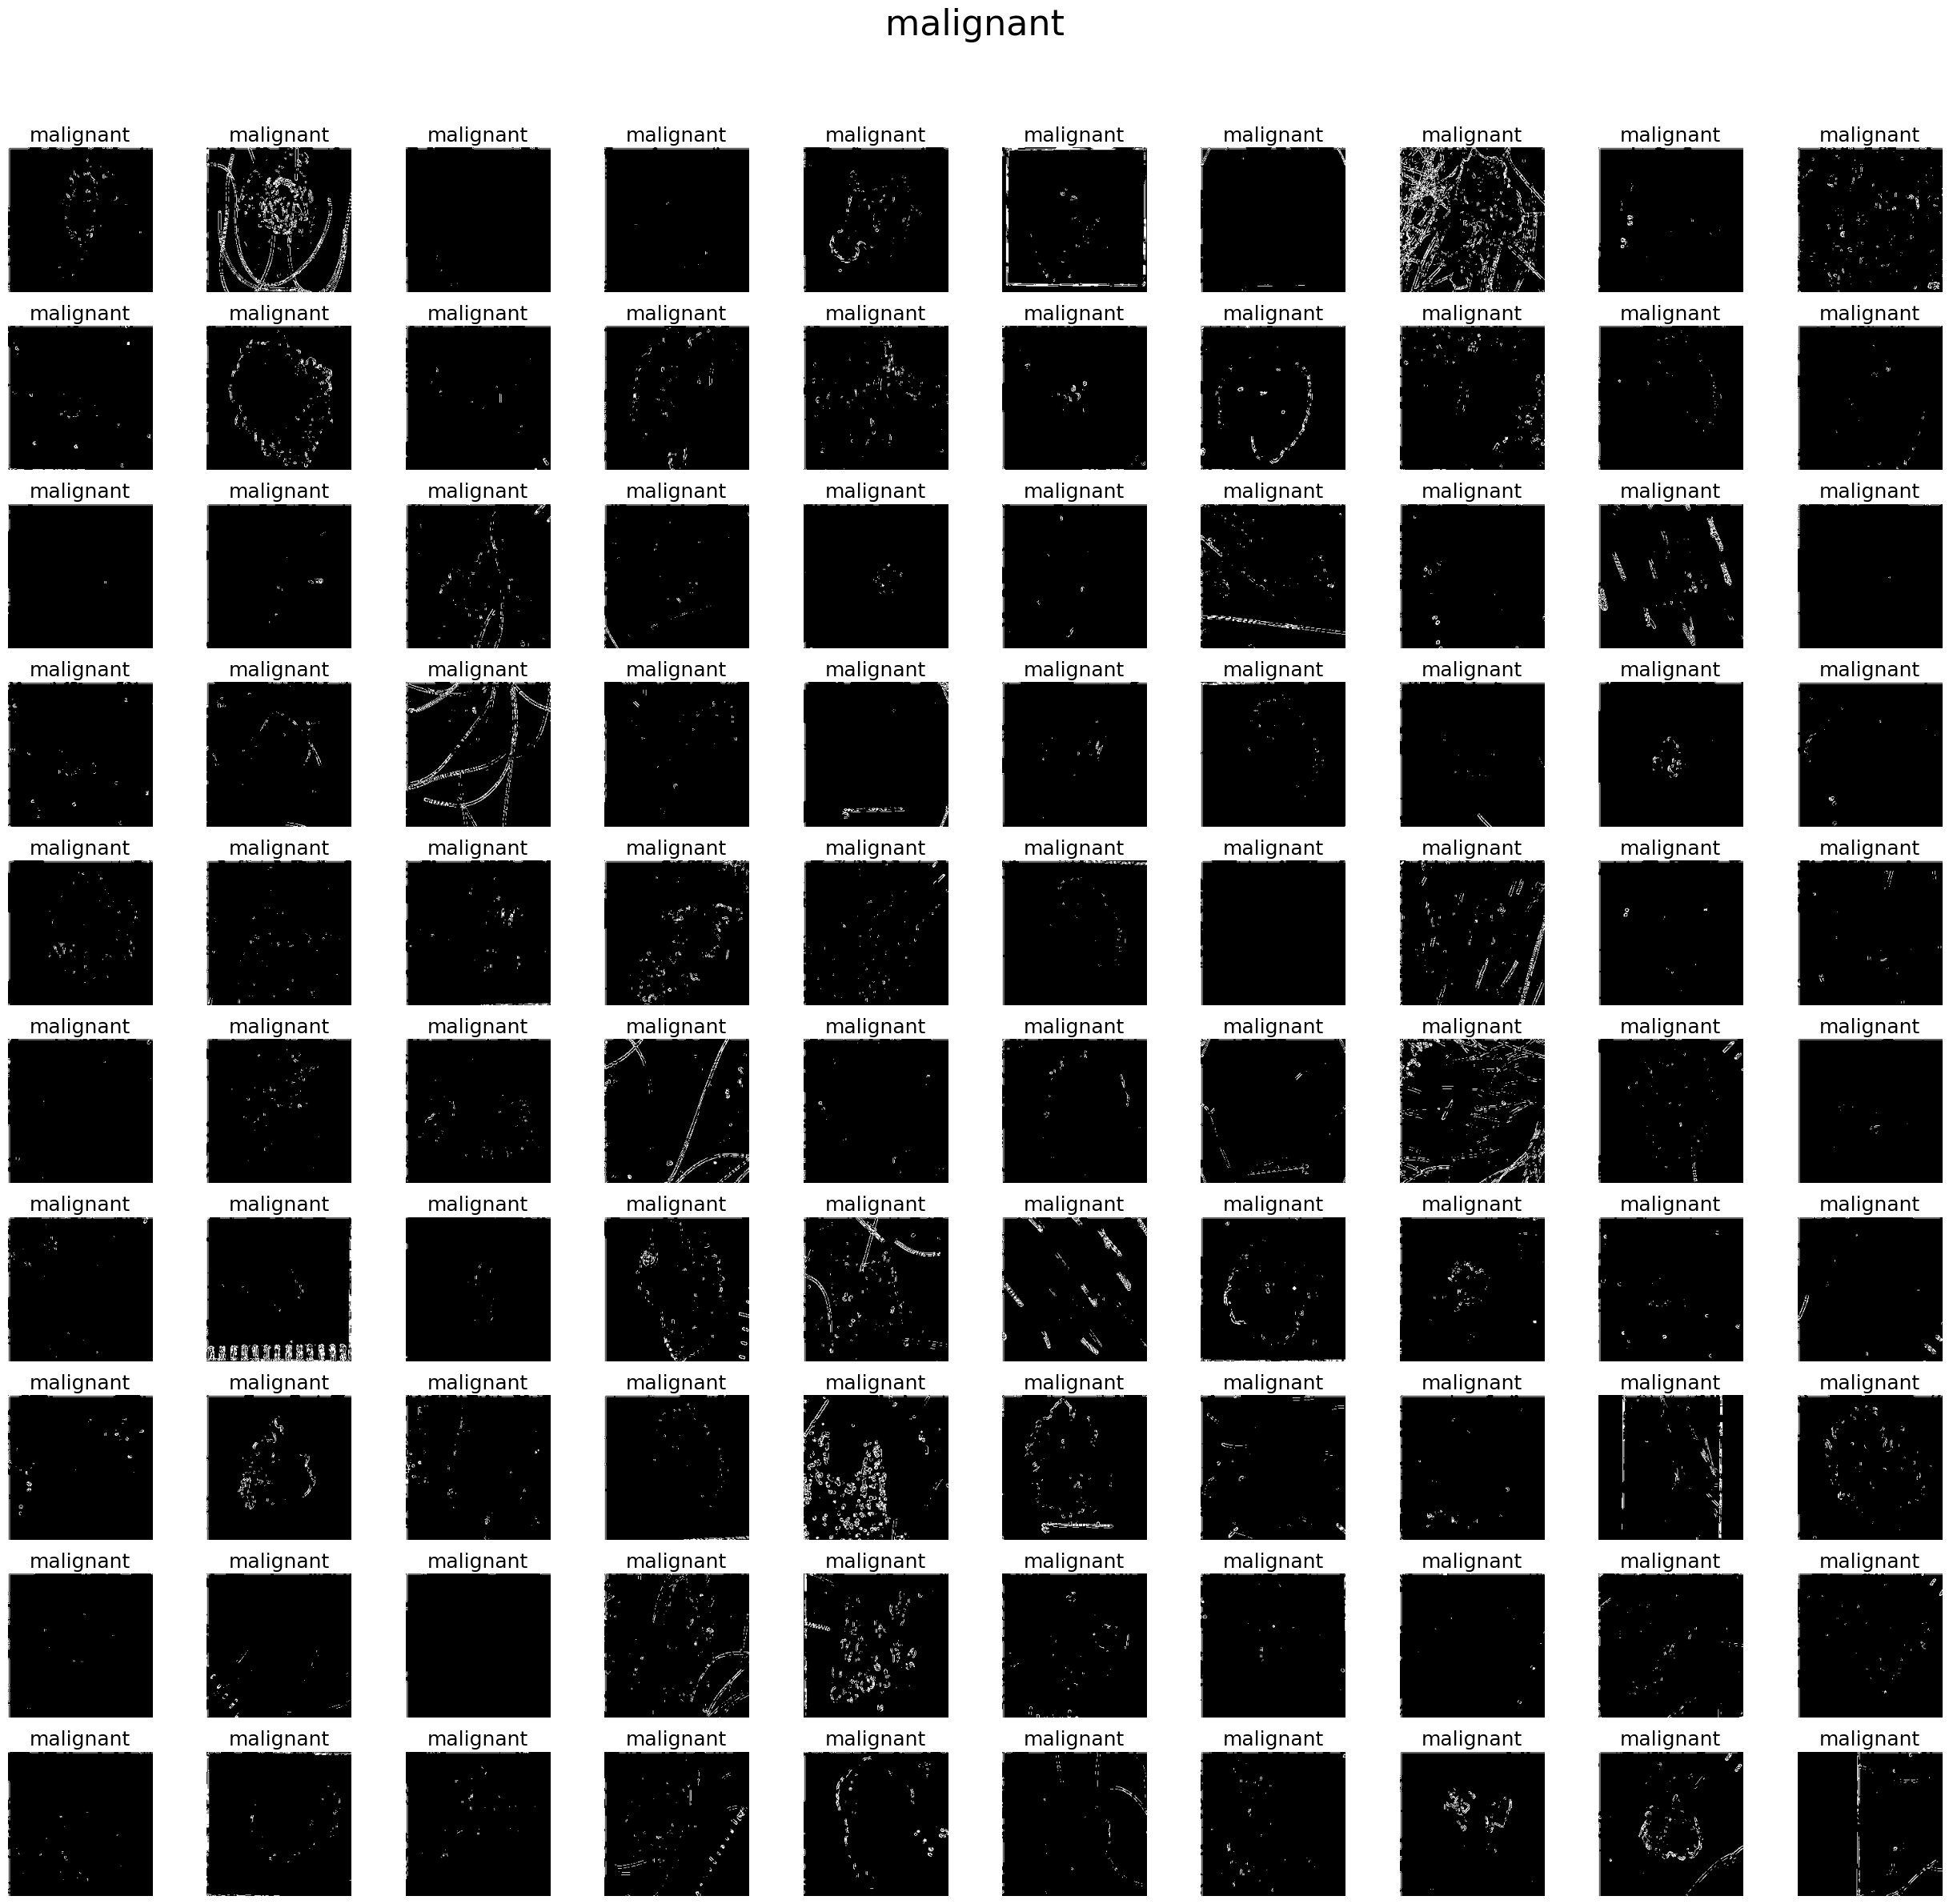

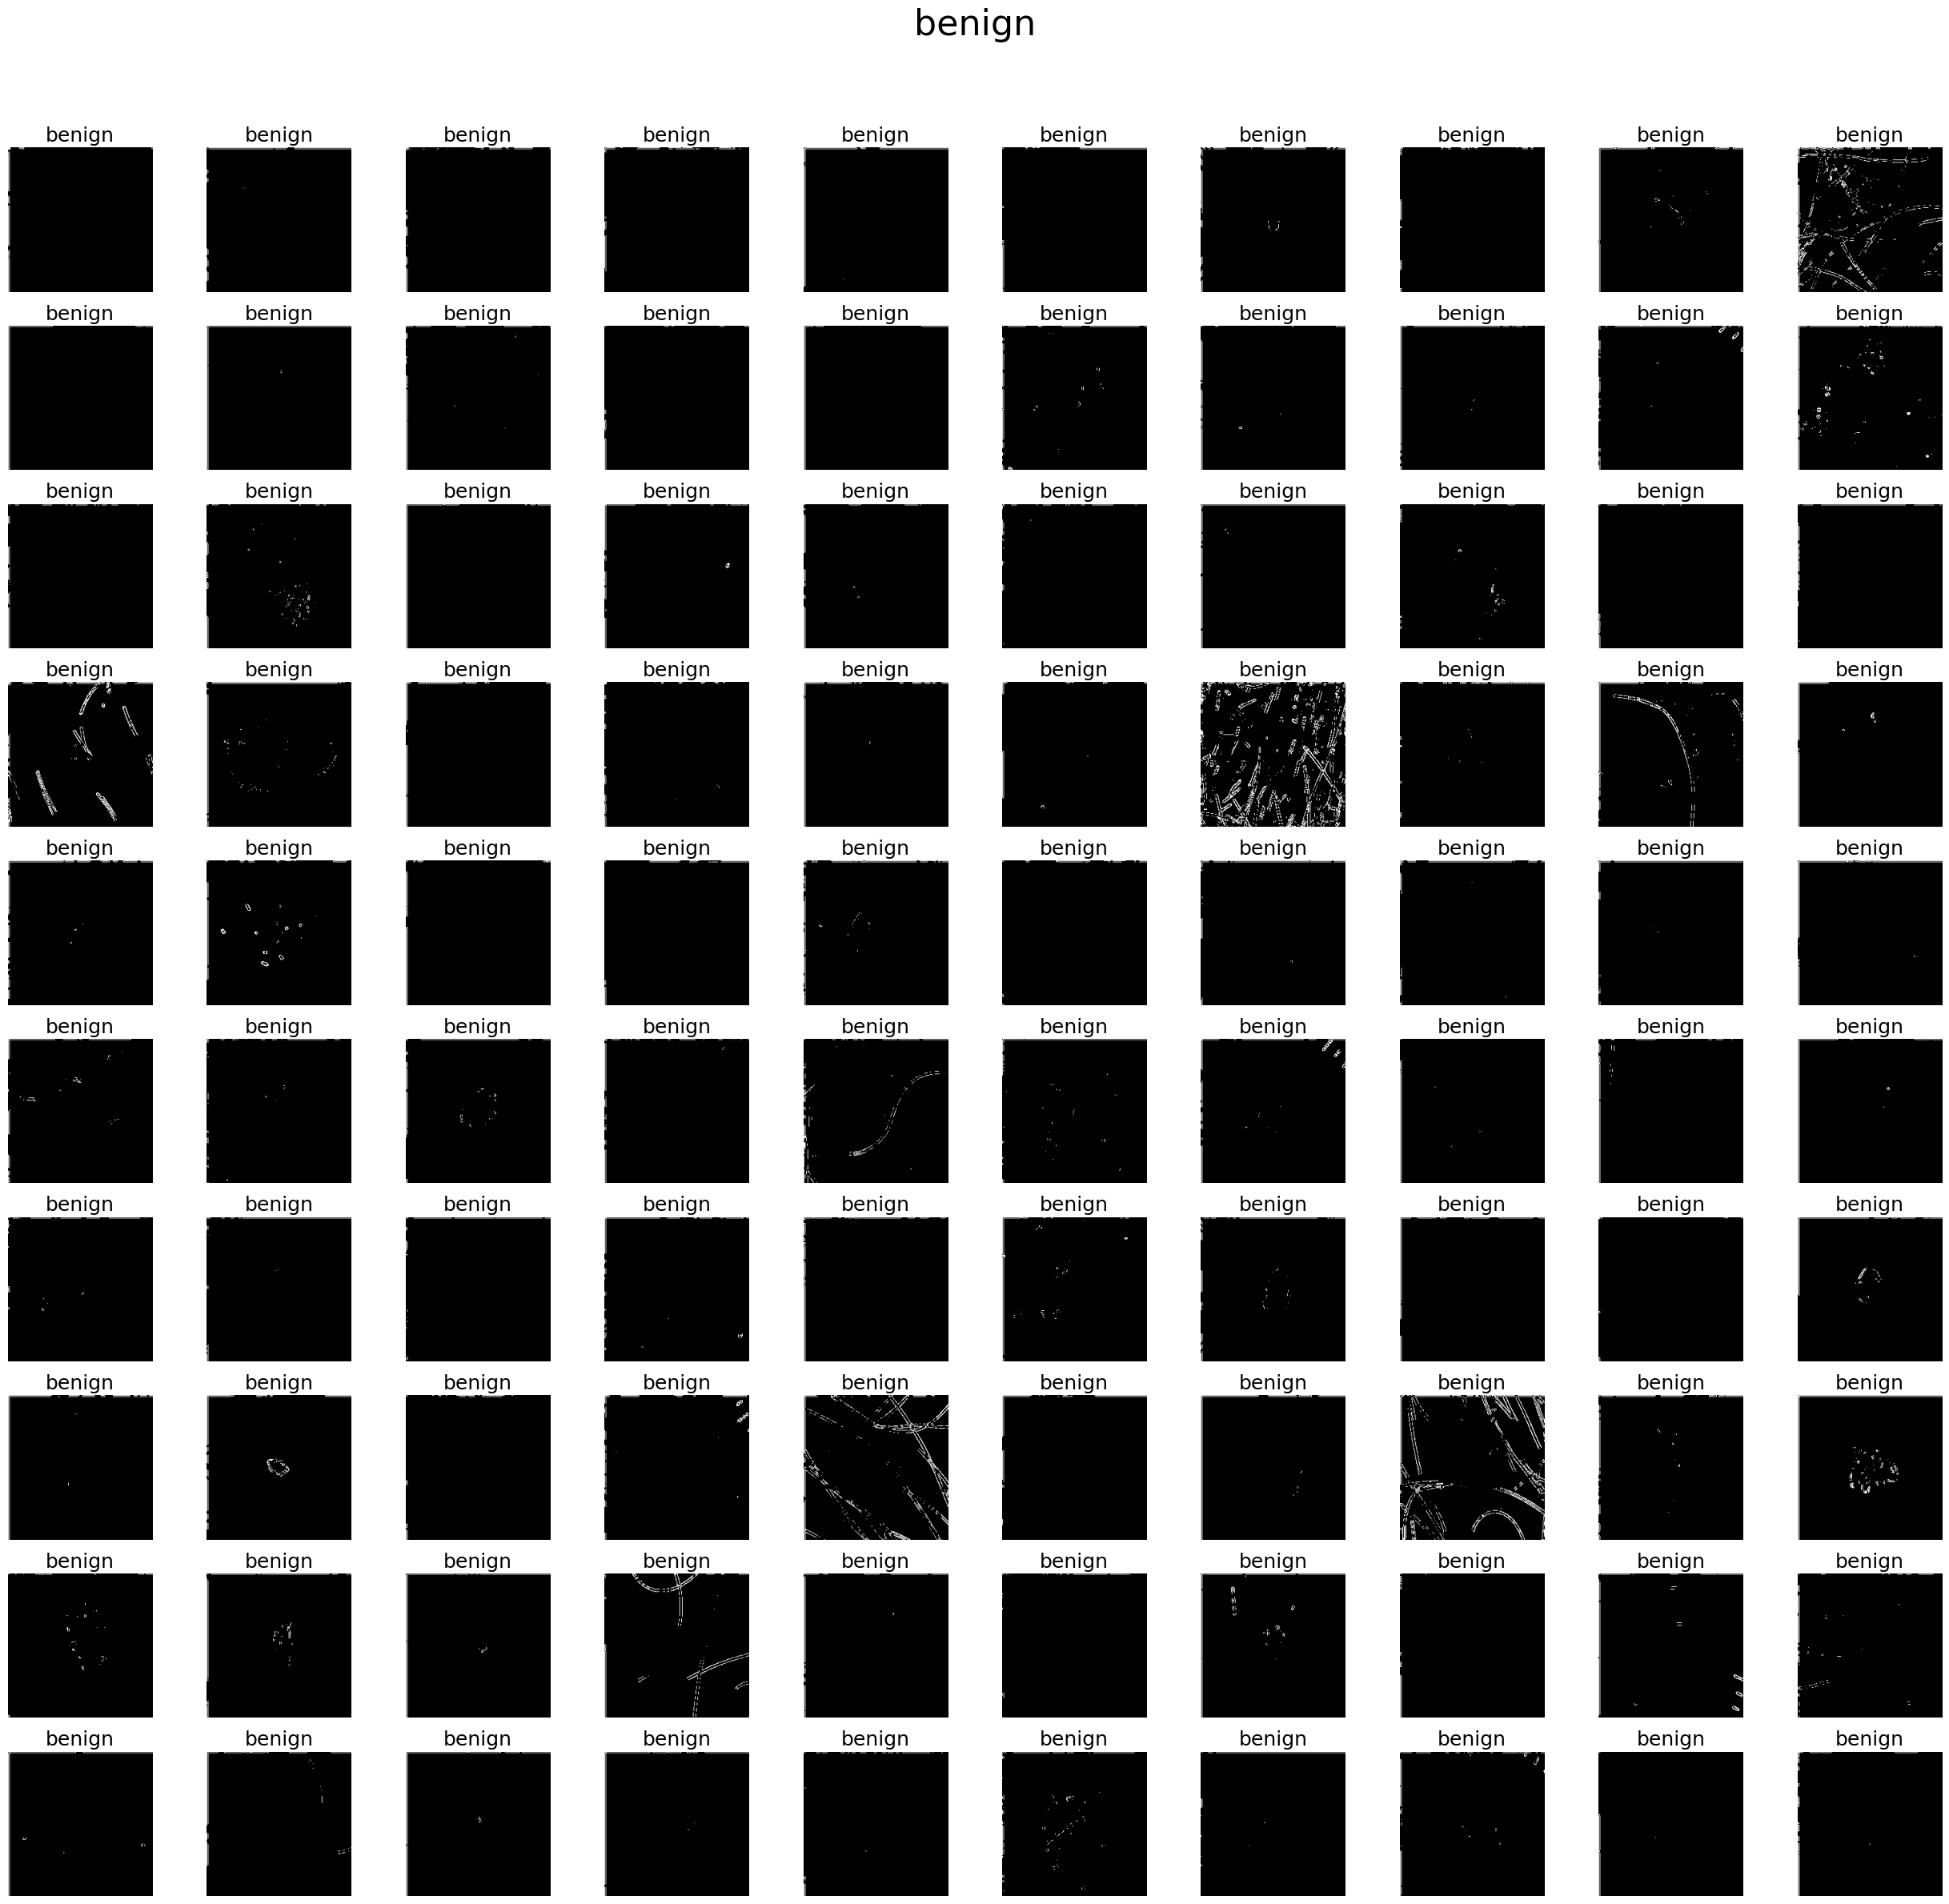

In [ ]:
step = 100
img_total = 200

for i in range(img_total // step):
    plt.figure(figsize=(25, 25))
    plt.suptitle(f"{labels[i * step]}", fontsize = 32)

    for j in range(step):
        plt.subplot(10, 10, j + 1)
        plt.imshow(dataPreprocessed[(i * step) + j], cmap="gray")
        plt.title(str(labels[(i * step) + j]), fontsize = 18)
        plt.axis(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Feature Extraction

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric = True, normed = True)
    
    return glcm

In [ ]:
def correlation(matriks):
	
	return graycoprops(matriks, 'correlation')[0, 0]

In [ ]:
def dissimilarity(matriks):
    
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [ ]:
def homogenity(matriks):
    
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [ ]:
def contrast(matriks):
    
    return graycoprops(matriks, 'contrast')[0, 0]

In [ ]:
def ASM(matriks):
    
    return graycoprops(matriks, 'ASM')[0, 0]

In [ ]:
def energy(matriks):
    
    return graycoprops(matriks, 'energy')[0, 0]

In [ ]:
def entropyGlcm(matriks):
    
    return entropy(matriks.ravel())

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []

for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [ ]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [ ]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [ ]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [ ]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [ ]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [ ]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [ ]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil-ekstraksi-percobaan-2-preprocessing-median-roberts-sobel-treshold.csv', index = False)

hasilEkstrak = pd.read_csv('hasil-ekstraksi-percobaan-2-preprocessing-median-roberts-sobel-treshold.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,54.jpg,malignant,1398.079156,1722.092240,1028.382247,1739.090873,0.978500,0.973517,0.984185,0.973255,...,0.951562,0.943716,0.972850,0.971588,0.975480,0.971450,0.338948,0.124076,0.518904,0.116000
1,409.jpg,malignant,8631.902126,9368.861731,6551.706138,9452.547306,0.867255,0.855921,0.899245,0.854634,...,0.718273,0.685279,0.832087,0.828368,0.847510,0.827816,0.310421,0.243611,0.472815,0.236855
2,1215.jpg,malignant,292.893678,643.332864,501.173627,651.178387,0.995496,0.990107,0.992293,0.989986,...,0.980709,0.979405,0.991286,0.989729,0.990308,0.989649,0.649974,0.070215,0.338004,0.062382
3,949.jpg,malignant,792.765555,1540.337630,837.025044,1541.645217,0.987808,0.976312,0.987128,0.976292,...,0.959795,0.953269,0.980070,0.976375,0.979691,0.976355,0.555373,-0.005242,0.531879,-0.005258
4,1267.jpg,malignant,1226.248198,1834.544732,1422.812400,1818.853687,0.981142,0.971788,0.978119,0.972029,...,0.943309,0.938569,0.971890,0.968700,0.971241,0.968798,0.489326,0.175130,0.379946,0.183112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,820.jpg,benign,566.261111,1210.825675,919.035274,1175.520823,0.991292,0.981379,0.985867,0.981922,...,0.965659,0.963387,0.984468,0.981246,0.982679,0.981523,0.607550,0.013807,0.307423,0.041560
196,1350.jpg,benign,83.311980,904.850289,857.853039,904.850289,0.998719,0.986085,0.986808,0.986085,...,0.972691,0.972420,0.990267,0.986114,0.986251,0.986114,0.929178,-0.004125,0.076805,-0.004125
197,1173.jpg,benign,786.256807,1187.289107,574.071609,1165.060126,0.987909,0.981741,0.991172,0.982083,...,0.969608,0.963700,0.983452,0.981524,0.984687,0.981682,0.420835,0.022767,0.592060,0.042074
198,893.jpg,benign,492.061379,479.884474,32.543742,481.192061,0.992433,0.992620,0.999500,0.992600,...,0.989402,0.984963,0.992367,0.992473,0.994687,0.992453,0.016927,0.038071,0.950439,0.037952


### Features Selection

<Axes: >

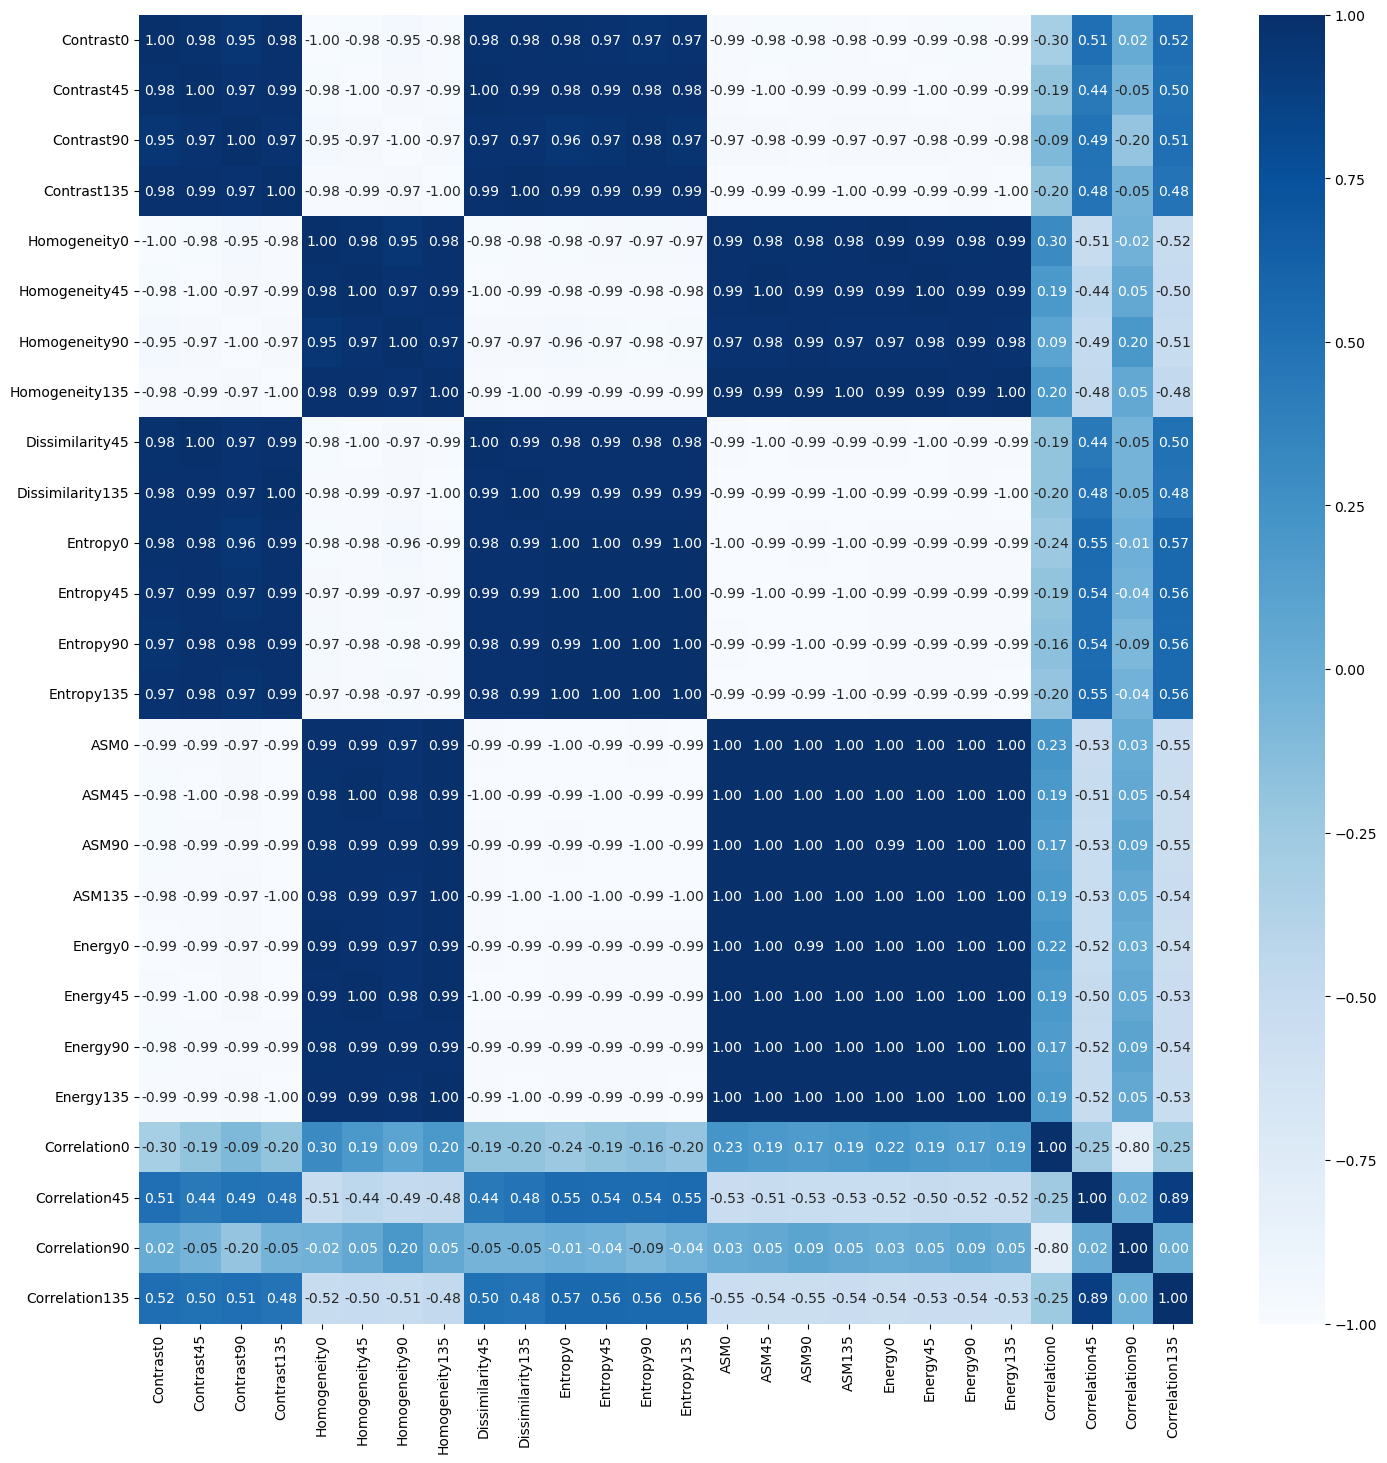

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 1 dengan label
threshold = 1
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)

for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False

select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]

x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']

plt.figure(figsize=(17, 17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 26)
(40, 26)


## Feature Normalization

In [ ]:
# normalisasi mean dengan standardization (Z-score)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      benign       0.97      0.95      0.96        81
   malignant       0.95      0.97      0.96        79

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

[[77  4]
 [ 2 77]]
Accuracy: 0.9625

------Testing Set------
              precision    recall  f1-score   support

      benign       0.76      0.68      0.72        19
   malignant       0.74      0.81      0.77        21

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40

[[13  6]
 [ 4 17]]
Accuracy: 0.75


### Train SVM Classifier

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      benign       0.78      0.81      0.80        81
   malignant       0.80      0.76      0.78        79

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.79      0.79      0.79       160

[[66 15]
 [19 60]]
Accuracy: 0.7875

------Testing Set------
              precision    recall  f1-score   support

      benign       0.88      0.79      0.83        19
   malignant       0.83      0.90      0.86        21

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[15  4]
 [ 2 19]]
Accuracy: 0.85


### Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------


              precision    recall  f1-score   support

      benign       0.82      0.77      0.79        81
   malignant       0.77      0.82      0.80        79

    accuracy                           0.79       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.80      0.79      0.79       160

[[62 19]
 [14 65]]
Accuracy: 0.79375

------Testing Set------
              precision    recall  f1-score   support

      benign       1.00      0.74      0.85        19
   malignant       0.81      1.00      0.89        21

    accuracy                           0.88        40
   macro avg       0.90      0.87      0.87        40
weighted avg       0.90      0.88      0.87        40

[[14  5]
 [ 0 21]]
Accuracy: 0.875


## Evaluation With Confusion Matrix

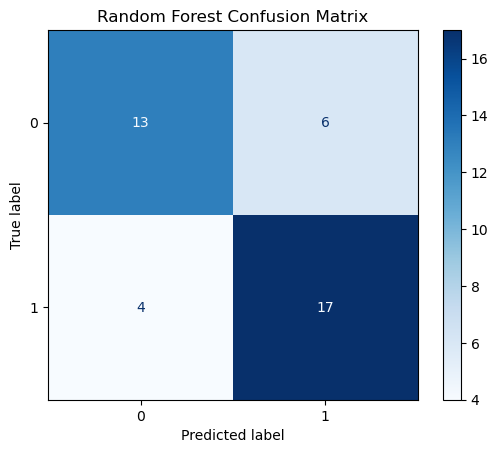

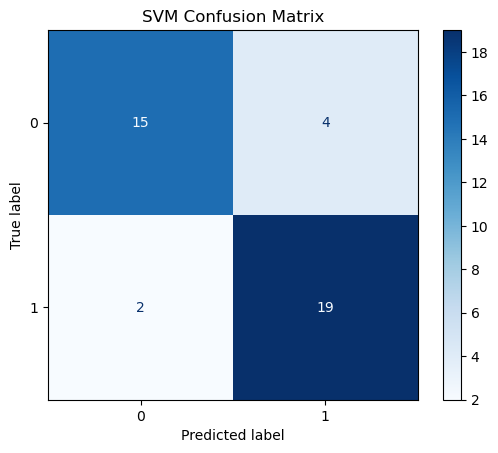

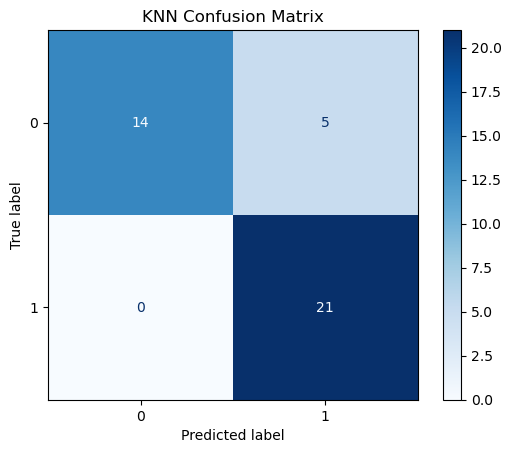

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")

# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")

# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")